In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nilearn import datasets, image, plotting
from nilearn.masking import apply_mask
from nilearn.signal import clean
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [28]:
sub = '02'
run = 'learning1'
tr = 2.33384

In [17]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

sub_ids = load_participant_list(base_dir)

In [18]:
# Load a V1 mask
# Example using Juelich atlas (probabilistic)
juelich = datasets.fetch_atlas_juelich('maxprob-thr50-1mm')
labels = juelich.labels
# Suppose index 8 is V1 left
v1_index = 48
print(labels[v1_index])  # Look for 'Primary visual cortex' or 'V1'

v1_mask_img = image.math_img("img == %d" % v1_index, img=juelich.maps)

GM Visual cortex V1 BA17


In [19]:
#plotting.plot_roi(v1_mask_img, title='V1 mask', display_mode='mosaic')

In [20]:
subject = Subject(base_dir, sub, include_modeling=False, include_imaging=True, bids_dir=bids_dir)

In [21]:
# Load fMRI volume
img_path = subject.img.get(run)
fmri_img = image.load_img(img_path)

# resample mask
v1_mask_img = image.resample_to_img(v1_mask_img, fmri_img, interpolation='nearest')

In [22]:
# Load events
events = getattr(subject, run).events

In [23]:
# Load confounds
confounds, sample_mask = subject.load_confounds(run, motion_type='basic')
physio_regressors = subject.load_physio_regressors(run)
confounds = confounds.join(physio_regressors)

In [24]:
masked_img = apply_mask(fmri_img, v1_mask_img)
cleaned_masked_img = clean(masked_img, confounds=confounds, t_r=tr, detrend = True,
                           standardize='zscore_sample')

/tmp/ipykernel_295346/2199374517.py:2: DeprecationWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  cleaned_masked_img = clean(masked_img, confounds=confounds, t_r=tr, detrend = True,


In [25]:
n_volumes = fmri_img.shape[-1]
window_size = 10
trial_onsets = events[events['trial_type'] == 'first_stim_presentation']['onset'].values
trial_onsets = trial_onsets/tr  # convert to volumes
trial_onsets = np.round(trial_onsets).astype(int)  # round to nearest volume

# Extract time series from V1
v1_time_series = cleaned_masked_img.mean(axis=1)  # average across voxels

# Collect trial-aligned windows
aligned_trials = []
for onset in trial_onsets:
    if onset + window_size <= n_volumes:
        window = v1_time_series[onset:onset + window_size]
        aligned_trials.append(window)

aligned_trials = np.array(aligned_trials)
average_response = aligned_trials.mean(axis=0)

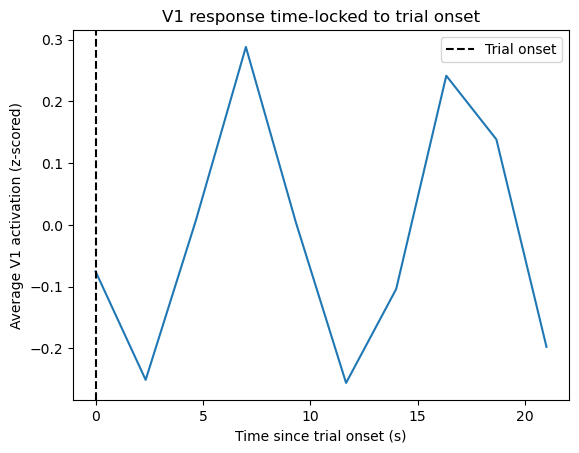

In [26]:
time_axis = np.arange(window_size) * tr
plt.plot(time_axis, average_response)
plt.xlabel('Time since trial onset (s)')
plt.ylabel('Average V1 activation (z-scored)')
plt.title('V1 response time-locked to trial onset')
plt.axvline(0, color='k', linestyle='--', label='Trial onset')
plt.legend()
plt.show()